# 👋 Welcome to the **CRAFT** Pytorch tutorial


In this tutorial, we will take a model, several images and run CRAFT to extract concepts and then display them using Concept Attribution Maps.

💡 In order to better understand what we are going to do, you may want to read the original paper before:
[Concept Recursive Activation Factorisation (CRAFT)](https://arxiv.org/pdf/2211.10154.pdf).

_Authors: [Thomas FEL](https://thomasfel.fr/), [Agustin PICARD](), [Louis Béthune](), [Thibaut Boissin]()_

# 1 - Loading and preparing the model

🛠 CRAFT requires splitting the model in two parts. So, we will prepare two functions $(g, h)$ such that $f(x) = (g \cdot h)(x)$. To put it simply, $g$ is the function that maps our input to the latent space (the penultimate layer of our model), and $h$ is the function that maps this penultimate layer to the output. It is important to note that if the model contains a global average pooling layer, it is strongly recommended to provide CRAFT with the layer before the global average pooling.

⚠️ Please keep in mind that the activations must be positives (after relu or any positive activation function)

https://github.com/deel-ai/Craft/blob/main/craft/craft_torch.py

In [ ]:
!tar -cvzf gender_500.tar.gz inputs/

inputs/
inputs/1/
inputs/1/26_1_2_20170109213532617.jpg
inputs/1/2_1_0_20170109194054994.jpg
inputs/1/15_1_3_20170104221725742.jpg
inputs/1/6_1_0_20170109204905156.jpg
inputs/1/8_1_2_20170109201847910.jpg
inputs/1/76_1_0_20170110131744527.jpg
inputs/1/18_1_0_20170109214753528.jpg
inputs/1/16_1_0_20170102234728107.jpg
inputs/1/15_1_4_20170103200935782.jpg
inputs/1/26_1_2_20170104021717909.jpg
inputs/1/53_1_0_20170103183702714.jpg
inputs/1/25_1_3_20170104222350215.jpg
inputs/1/13_1_4_20170103200913055.jpg
inputs/1/25_1_0_20170103180835288.jpg
inputs/1/54_1_0_20170103183742275.jpg
inputs/1/1_1_2_20161219220519457.jpg
inputs/1/7_1_2_20161219204222117.jpg
inputs/1/14_1_0_20170109203638205.jpg
inputs/1/65_1_0_20170110175333844.jpg
inputs/1/47_1_0_20170109221107171.jpg
inputs/1/19_1_4_20170102235050099.jpg
inputs/1/3_1_0_20170103212052443.jpg
inputs/1/60_1_0_20170110125212119.jpg
inputs/1/39_1_0_20170109141437262.jpg
inputs/1/1_1_3_20161219224650392.jpg
inputs/1/52_1_0_20170110122705423.jpg
i

In [ ]:
!ls -lh gender_500.tar.gz

-rw-r--r-- 1 root root 37M Nov  8 05:26 gender_500.tar.gz


In [ ]:
!pip install Craft-xai

In [ ]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from PIL import Image
import shutil
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image as to_pil
from torchvision.transforms.functional import to_tensor as transform


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from torch.utils.data import DataLoader
from torchvision import datasets
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4


In [ ]:
class DatasetPreparation:
    def __init__(self, base_dir, n_samples=500, seed=42):
        self.base_dir = base_dir
        self.n_samples = n_samples
        np.random.seed(seed)

    def load_and_sample_images(self):
        """
        Load and randomly sample images while preserving metadata from filenames
        """
        all_files = [f for f in os.listdir(self.base_dir) if f.endswith('.jpg')]

        # Randomly sample n_samples files
        selected_files = np.random.choice(all_files, size=self.n_samples, replace=False)

        # Create metadata dictionary
        metadata = []
        images = []

        for filename in selected_files:
            # Parse filename
            age, gender, race, datetime = filename.split('_')

            metadata.append({
                'filename': filename,
                'age': int(age),
                'gender': int(gender),
                'race': int(race),
                'datetime': datetime.split('.')[0]
            })

            os.makedirs('/content/inputs/0', exist_ok=True)
            os.makedirs('/content/inputs/1', exist_ok=True)

            src_path = os.path.join(self.base_dir, filename)
            dst_path = os.path.join('/content/inputs', gender, filename)
            shutil.copy(src_path, dst_path)

            # Load image

            img = Image.open(dst_path).convert('RGB')
            img = img.resize((160, 160))
            images.append(np.array(img))

        return np.array(images), pd.DataFrame(metadata)

    def get_balanced_sample(self):
        """
        Get samples while maintaining balance across gender and race
        """
        images, metadata = self.load_and_sample_images()

        # Convert to torch tensor and normalize
        images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0

        return images, metadata

dataset_prep = DatasetPreparation(base_dir='/content/part1', n_samples=500)
images, metadata = dataset_prep.get_balanced_sample()


In [ ]:
class FaceNetEncoder(torch.nn.Module):
    def __init__(self, facenet_model, split_layer='Mixed_7a'):
        super().__init__()
        # Get all layers up to Mixed_7a (pre-bottleneck)
        self.features = torch.nn.ModuleList()
        for layer in facenet_model.children():
            if isinstance(layer, InceptionResnetV1):
                for block in layer.children():
                    self.features.append(block)
                    if block._get_name() == split_layer:
                        break

    def forward(self, x):
        # Ensure positive activations with ReLU
        for layer in self.features:
            x = layer(x)
        return torch.nn.functional.relu(x)

class FaceNetDecoder(torch.nn.Module):
    def __init__(self, facenet_model, split_layer='Mixed_7a'):
        super().__init__()
        # Get remaining layers after Mixed_7a
        self.classifier = torch.nn.ModuleList()
        found_split = False
        for layer in facenet_model.children():
            if isinstance(layer, InceptionResnetV1):
                for block in layer.children():
                    if found_split:
                        self.classifier.append(block)
                    if block._get_name() == split_layer:
                        found_split = True

    def forward(self, x):
        for layer in self.classifier:
            x = layer(x)
        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Running on device: cpu


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load("./model_bce_loss.pytorch"))

device = 'cuda'
model = model.eval().to(device)

<ipython-input-7-feca12f88661>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model_bce_loss.pytorch"))


In [ ]:

from craft.craft_torch import Craft, torch_to_numpy

g = FaceNetEncoder(facenet)
h = FaceNetDecoder(facenet)

craft_model = Craft(
    input_to_latent=g,
    latent_to_logit=h,
    number_of_concepts=20,
    batch_size=32,
    device=device
)

In [ ]:
g

FaceNetEncoder(
  (features): ModuleList()
)

In [ ]:
h

FaceNetDecoder(
  (classifier): ModuleList()
)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/inputs')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999999
Face detected with probability: 0.999995
Face detected with probability: 0.999748
Face detected with probability: 0.998855
Face detected with probability: 1.000000
Face detected with probability: 0.998048
Face detected with probability: 0.999993
Face detected with probability: 0.999999
Face detected with probability: 0.999648
Face detected with probability: 0.999981
Face detected with probability: 0.999972
Face detected with probability: 0.999995
Face detected with probability: 0.999530
Face detected with probability: 0.999996
Face detected with probability: 0.999919
Face detected with probability: 0.999712
Face detected with probability: 0.999626
Face detected with probability: 0.999117
Face detected with probability: 0.999953
Face detected with probability: 0.998711
Face detected with probability: 0.999998
Face detected with probability: 0.999507
Face detected with probability: 0.998278
Face detected with probability: 0.999110
Face detected wi

In [ ]:
rabbit_class = 0
images_preprocessed = torch.stack([transform(to_pil(img)) for img in aligned], 0)
images_preprocessed.shape

torch.Size([499, 3, 160, 160])

In [ ]:
rabbit_class = 330 # imagenet class for rabbit

# loading some images of rabbits !
images = np.load('assets/rabbit.npz')['arr_0'].astype(np.uint8)
images_preprocessed = torch.stack([transform(to_pil(img)) for img in images], 0)

images_preprocessed.shape

torch.Size([300, 3, 256, 256])

# 2- How to use CRAFT


The API of CRAFT is really simple. We have 2 hyperparameters to define. First, the number of concepts ($r$ in the original paper), 10 is enough when we study the penultimate layer for a class of ImageNet. We provide tips and metrics to choose this hyperparameter below.

The second hyperparameter is the `patch_size`, or the size of the patches used for the concept extraction. For image of $224$, we encourage you to stay between $64$ and $128$ (half of the image).

Let's start by instantiating CRAFT



In [ ]:
from craft.craft_torch import Craft, torch_to_numpy

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 64,
              batch_size = 64,
              device = device)

# now we can start fit the concept using our rabbit images
# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
crops, crops_u, w = craft.fit(images_preprocessed)
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)

crops.shape, crops_u.shape, w.shape

/usr/local/lib/python3.10/dist-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


((1996, 64, 64, 3), (1996, 10), (10, 3))

# 3- Estimating the concept importance

The second crucial step before starting our investigation is to understand which concepts matter. To do so, we use Sobol indices and we compute them using a really simple api!

In [ ]:
importances = craft.estimate_importance(images_preprocessed, class_id=rabbit_class) # 330 is the rabbit class id in imagenet
images_u = craft.transform(images_preprocessed)

images_u.shape

/usr/local/lib/python3.10/dist-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(499, 160, 160, 10)

# 4 - Results !

Concept 8  has an importance value of  0.14555684
Concept 0  has an importance value of  0.13738677
Concept 2  has an importance value of  0.11756523
Concept 1  has an importance value of  0.0069133462
Concept 6  has an importance value of  0.0005233436


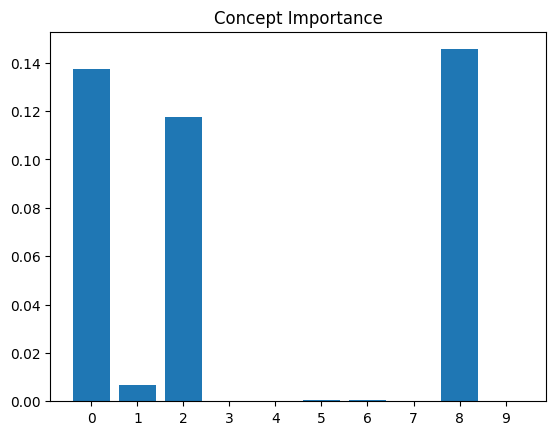

In [ ]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")

most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 8  has an importance value of  0.14555684


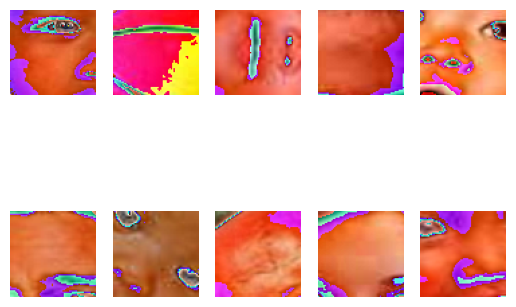




Concept 0  has an importance value of  0.13738677


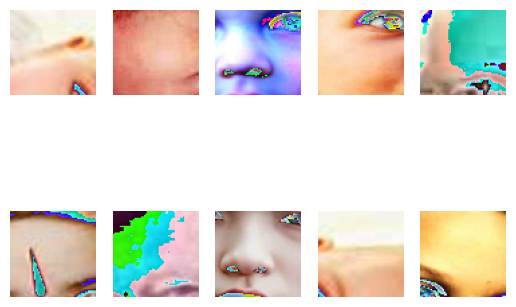




Concept 2  has an importance value of  0.11756523


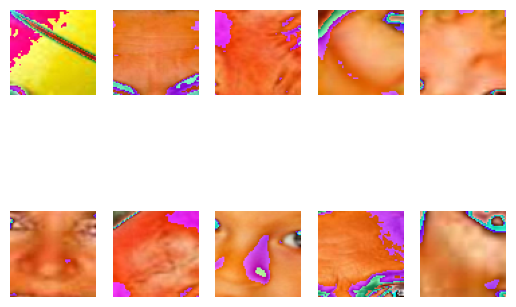




Concept 1  has an importance value of  0.0069133462


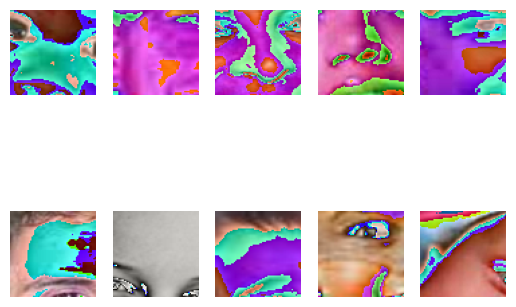




Concept 6  has an importance value of  0.0005233436


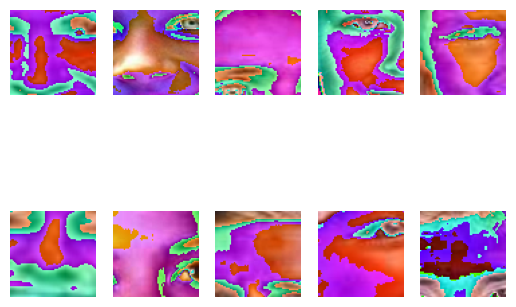

In [ ]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')

for c_id in most_important_concepts:

  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = crops[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])
  plt.show()
  print('\n\n')

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

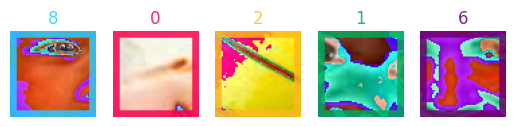

In [ ]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()

plot_legend()

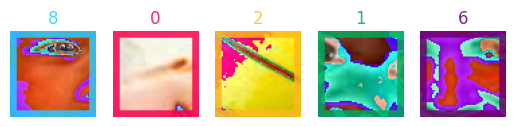

<ipython-input-23-a5d933dd4d9b>:11: RuntimeWarning: invalid value encountered in divide
  img -= img.min();img /= img.max()


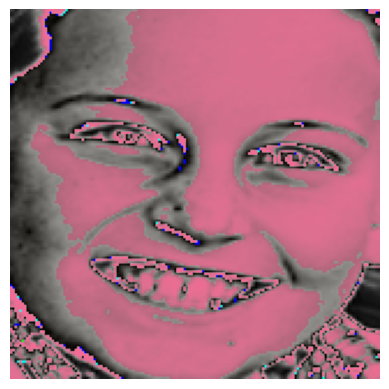

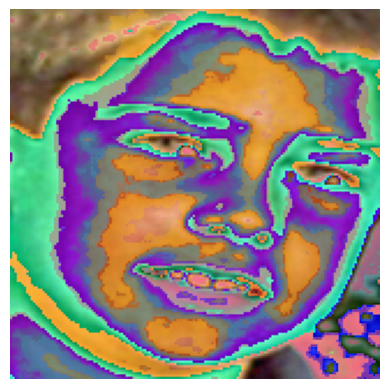

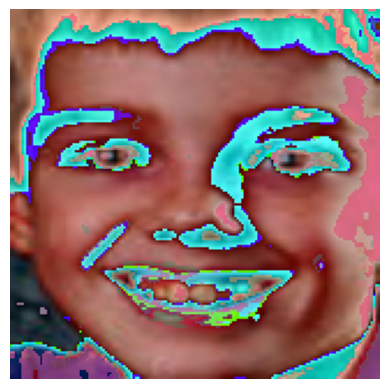

In [ ]:
def concept_attribution_maps(id, percentile=90):
  img = images_preprocessed[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(images_u[:,:,:,c_id].flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = cv2.resize(heatmap[:, :, None], (160, 160))
    show(heatmap, cmap=cmap, alpha=0.7)

  plt.show()

plot_legend()
concept_attribution_maps(0)
plt.show()
concept_attribution_maps(1)
plt.show()
concept_attribution_maps(2)
plt.show()